In [1]:
using CSV
using Plots
using DataFrames
using Statistics
using LinearAlgebra

In [2]:
df2 = CSV.read("EMS_2020_1.csv")

,CAD_INCIDENT_ID,INCIDENT_DATETIME,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE
,Int64,String,String,Int64
1,200010444,01/01/2020 01:16:49 AM,INJURY,5
2,200010001,01/01/2020 12:00:20 AM,UNKNOW,4
3,200010002,01/01/2020 12:00:38 AM,STATEP,2
4,200010003,01/01/2020 12:00:50 AM,UNKNOW,4
5,200010004,01/01/2020 12:01:30 AM,INJMAJ,3
6,200010005,01/01/2020 12:01:44 AM,ABDPN,5
7,200010006,01/01/2020 12:01:55 AM,UNC,2
8,200010007,01/01/2020 12:02:09 AM,CARD,3
9,200010009,01/01/2020 12:02:32 AM,INJURY,5


In [3]:
# let's list all available categories, as well as their datatype using the "eltype" function.
feature_names = names(df2)
for i in 1:size(feature_names)[1]
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df2[!, i])))
end

1	CAD_INCIDENT_ID			Int64
2	INCIDENT_DATETIME			String
3	INITIAL_CALL_TYPE			String
4	INITIAL_SEVERITY_LEVEL_CODE			Int64
5	FINAL_CALL_TYPE			String
6	FINAL_SEVERITY_LEVEL_CODE			Int64
7	FIRST_ASSIGNMENT_DATETIME			String
8	VALID_DISPATCH_RSPNS_TIME_INDC			String
9	DISPATCH_RESPONSE_SECONDS_QY			String
10	FIRST_ACTIVATION_DATETIME			String
11	FIRST_ON_SCENE_DATETIME			String
12	VALID_INCIDENT_RSPNS_TIME_INDC			String
13	INCIDENT_RESPONSE_SECONDS_QY			String
14	INCIDENT_TRAVEL_TM_SECONDS_QY			String
15	FIRST_TO_HOSP_DATETIME			String
16	FIRST_HOSP_ARRIVAL_DATETIME			String
17	INCIDENT_CLOSE_DATETIME			String
18	HELD_INDICATOR			String
19	INCIDENT_DISPOSITION_CODE			Float64
20	BOROUGH			String
21	INCIDENT_DISPATCH_AREA			String
22	ZIPCODE			Float64
23	POLICEPRECINCT			Float64
24	CITYCOUNCILDISTRICT			Float64
25	COMMUNITYDISTRICT			Float64
26	COMMUNITYSCHOOLDISTRICT			Float64
27	CONGRESSIONALDISTRICT			Float64
28	REOPEN_INDICATOR			String
29	SPECIAL_EVENT_INDICATOR			String
30	STANDBY_IND

In [25]:
df2.FINAL_CALL_TYPE	

128597-element Array{String,1}:
 "INJMAJ"
 "UNKNOW"
 "STATEP"
 "UNKNOW"
 "INJMAJ"
 "ABDPN"
 "UNC"
 "CARD"
 "INJURY"
 "RESPIR"
 "RESPIR"
 "UNC"
 "STATEP"
 ⋮
 "DRUG"
 "ABDPN"
 "INJMAJ"
 "EDP"
 "INJURY"
 "INJURY"
 "TRAUMA"
 "DRUG"
 "RESPIR"
 "OTHER"
 "EDP"
 "UNKNOW"

In [4]:
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

df2.INCIDENT_RESPONSE_SECONDS_QY = convert(Array, string_to_float.(df2.INCIDENT_RESPONSE_SECONDS_QY));

In [5]:
validFloat(x) = x::Float64 >=0
validInt(x) = x::Int64 >= 0

df2 = df2[(validFloat.(df2[!, :INCIDENT_RESPONSE_SECONDS_QY])), :];
df2 = df2[(validInt.(df2[!, :FINAL_SEVERITY_LEVEL_CODE])), :];

In [6]:
train_proportion = 0.8
n = size(df2, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))

target1 = df2[:, :FINAL_SEVERITY_LEVEL_CODE]
target2 = df2[:, :INCIDENT_RESPONSE_SECONDS_QY]
data = df2[:, filter(col -> (col != "FINAL_SEVERITY_LEVEL_CODE" && col != "INCIDENT_RESPONSE_SECONDS_QY"), feature_names)]

#Now you will split the data to create training and test sets. 

# the following variable records the features of examples in the training set
train_x = data[1:ntrain,:]
# the following variable records the features of examples in the test set
test_x = data[ntrain+1:end,:]
# the following variable records the labels of examples in the training set
train_y1 = target1[1:ntrain]
train_y2 = target2[1:ntrain]
# the following variable records the labels of examples in the test set
test_y1 = target1[ntrain+1:end];
test_y2 = target2[ntrain+1:end];

Size of dataset: 128597


In [7]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return norm(y - pred) / sqrt(size(y,1))
end

"""This completed function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This completed helper funciton plots x vs, y and labels the axes."""
function plotdata(x, y, xname, yname; margin=0.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", zeromin=true)
end

plot_pred_true

In [8]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    result = zeros(size(column, 1), size(cats,1))
    for col_idx = 1:size(column,1)
        for cats_idx = 1:size(cats,1)
            comparison = column[col_idx] == cats[cats_idx]
            
            if (!ismissing(comparison) && comparison)
                result[col_idx, cats_idx] = 1
                break
            end
        end
    end
    return result
end

onehot

In [9]:
#Sets of all zip codes
zipcodes = unique(train_x[:ZIPCODE])

train_zip = onehot(train_x[:ZIPCODE], zipcodes)
test_zip = onehot(test_x[:ZIPCODE], zipcodes)

println(size(train_zip))
println(size(test_zip))

(102878, 220)
(25719, 220)


In [10]:
idas = unique(train_x[:INCIDENT_DISPATCH_AREA])

train_ida = onehot(train_x[:INCIDENT_DISPATCH_AREA], idas)
test_ida = onehot(test_x[:INCIDENT_DISPATCH_AREA], idas)

println(size(train_ida))
println(size(test_ida))

(102878, 33)
(25719, 33)


In [11]:
pp = unique(train_x[:POLICEPRECINCT])

train_pp = onehot(train_x[:POLICEPRECINCT], pp)
test_pp =  onehot(test_x[:POLICEPRECINCT], pp)

println(size(train_pp))
println(size(test_pp))

(102878, 78)
(25719, 78)


In [12]:
ccd = unique(train_x[:CITYCOUNCILDISTRICT])

train_ccd = onehot(train_x[:CITYCOUNCILDISTRICT], ccd)
test_ccd =  onehot(test_x[:CITYCOUNCILDISTRICT], ccd)

println(size(train_ccd))
println(size(test_ccd))

(102878, 52)
(25719, 52)


In [13]:
cd = unique(train_x[:COMMUNITYDISTRICT])

train_cd = onehot(train_x[:COMMUNITYDISTRICT], cd)
test_cd =  onehot(test_x[:COMMUNITYDISTRICT], cd)

println(size(train_cd))
println(size(test_cd))

(102878, 72)
(25719, 72)


In [14]:
csd = unique(train_x[:COMMUNITYSCHOOLDISTRICT])

train_csd = onehot(train_x[:COMMUNITYSCHOOLDISTRICT], csd)
test_csd =  onehot(test_x[:COMMUNITYSCHOOLDISTRICT], csd)

println(size(train_csd))
println(size(test_csd))

(102878, 33)
(25719, 33)


In [15]:
cod = unique(train_x[:CONGRESSIONALDISTRICT])

train_cod = onehot(train_x[:CONGRESSIONALDISTRICT], cod)
test_cod =  onehot(test_x[:CONGRESSIONALDISTRICT], cod)

println(size(train_cod))
println(size(test_cod))

(102878, 14)
(25719, 14)


In [20]:
function getMSE(train_data, test_data, train_y, test_y)
    w = train_data\train_y
    
    train_pred = train_data*w
    test_pred = test_data*w
    
    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)
    
    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

return plot_pred_true(test_pred, test_y)
end

getMSE (generic function with 1 method)

In [21]:
# train_l = hcat(train_zip, train_ida, train_pp, train_ccd, train_cd, train_csd, train_cod, ones(size(train_zip, 1)))
# test_l = hcat(test_zip, test_ida, test_pp, test_ccd, test_cd, test_csd, test_cod, ones(size(test_zip, 1)));

train_l = hcat(train_csd, train_cod, ones(size(train_zip, 1)))
test_l = hcat(test_csd, test_cod, ones(size(test_zip, 1)));

Train MSE	1.7140615642754167
Test MSE 	1.7302207026450378


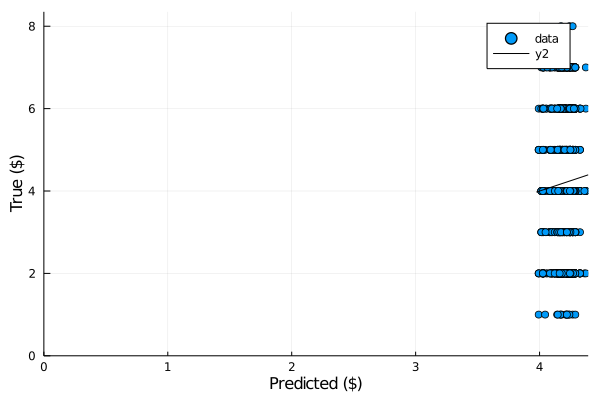

In [22]:
getMSE(train_l, test_l, train_y1, test_y1)

Train MSE	244.82432228043098
Test MSE 	244.33607283801862


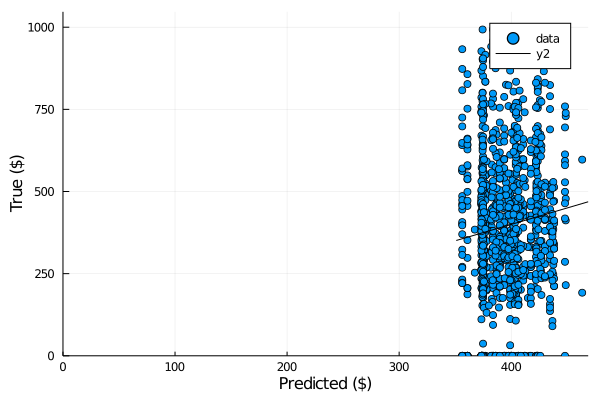

In [23]:
getMSE(train_l, test_l, train_y2, test_y2)

Just ZIP codes:

    1.7295288001281632
    
    244.09082247806043

Just incident dispatch area IDA: 

    1.7300987307568254
    
    244.4137904067201
    
Just Police Precinct: 

    1.729786364939992
    
    244.32478488202017
    
Just CITY COUNCIL DISTRICT ccd: 

    1.7310175227733298
    
    244.4194235733779
    
Just COMMUNITY DISTRICT cd: 

    1.7303603508426917
    
    244.286721718567
    
Just COMMUNITY SCHOOL DISTRICT csd: 

    1.7307838217109863
    
    244.40418050879296 
    
Just CONGRESSIONAL DISTRICT cod: 

    1.7307620591570683
    
    244.8147478462024

ZIP + IDA: 

    1.7295766494472837 
    
    244.05515039364235

Everything???:

    1.7299661381869818

    244.27525873193565

In [ ]:
df1 = CSV.read("911_End-to-End_Data.csv")
df1 = df1[df1[:Agency].=="EMS",:]

# let's list all available categories, as well as their datatype using the "eltype" function.
feature_names = names(df1)
for i in 1:size(feature_names)[1]
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df1[!, i])))
end